In [1]:
from prod.set_seed import random_ctl
seed = random_ctl(432286)

from fastai.text import *
from fastai.callbacks import SaveModelCallback
from fastai.layers import LabelSmoothingCrossEntropy

import sentencepiece as spm #https://github.com/google/sentencepiece
import fire

from sp_tok import *
from prod.bin_metrics import Fbeta_binary
from sklearn.model_selection import KFold
from prod.nlp_mixup import *

def split_rebal_data_by_idx(all_texts_df:DataFrame, train_idx, valid_idx,
                            clas_col:str='is_humor'):
    ## rebalance cases
    print('Number of positive samples:', (all_texts_df.loc[:,clas_col] == 1).sum())
    print('Number of negative samples:',  (all_texts_df.loc[:,clas_col] == 0).sum())
    print('Total samples:', len(all_texts_df))

    df_train_all = all_texts_df.iloc[train_idx,:]
    df_valid     = all_texts_df.iloc[valid_idx,:]

    print('Valid prevalence(n = %d):'%len(df_valid),df_valid.loc[:,clas_col].sum()/ len(df_valid))
    print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.loc[:,clas_col].sum()/ len(df_train_all))
    print('all samples (n = %d)'%len(all_texts_df))
    assert len(all_texts_df) == (len(df_valid)+len(df_train_all)),'math didnt work'

    ## assumes that negative is less frequent case.  Generalize?
    rows_pos = df_train_all.loc[:,clas_col] == 1
    df_train_pos = df_train_all.loc[rows_pos]
    df_train_neg = df_train_all.loc[~rows_pos]
    print(f'Train Pos Cases:{df_train_pos.shape},Train Neg Cases:{df_train_neg.shape}')
    df_resample_pos = df_train_pos.sample(n=len(df_train_neg),replace=True,
                                          axis=0,random_state=np.random.get_state()[1][0]).reset_index(drop=True)
    df_train = pd.concat([df_resample_pos,df_train_neg],axis=0) #randomized again in DataBunch?
    print('Train prevalence (n = %d):'%len(df_train), df_train.loc[:,clas_col].sum()/ len(df_train))

    return df_train, df_valid
        

Using seed: 432286


In [2]:
model_path:str='./data/rnn/'
sp_model:str='./all_tweets_es_0609'
flat_loss:bool=True
qrnn:bool=True
n_hid:int=2304 
load_enc:str='twitter_es_enc_QRNN_0609_drop1_seed0_finetune'
split_seed:int=20190303
backward:bool=False
wd:float=0.02 ## updated

In [3]:
PATH = Path(model_path)
# torch.backends.cudnn.enabled=False

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer, sp_model, pre_rules=default_rules)

all_texts_df = pd.read_csv('./data/haha_2019_train.csv')
raw_text = all_texts_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules: raw_text = raw_text.apply(lambda x: rule(str(x)))
all_texts_df['new_text'] = raw_text #databunch adds `xxbos` so don't add here

kfolder = KFold(n_splits=5, random_state=split_seed, shuffle=True)
for n_fold, (train_idx,valid_idx) in enumerate(kfolder.split(all_texts_df)):
    print(f'Kfold: {n_fold} of 5')
    df_train,df_valid = split_rebal_data_by_idx(all_texts_df,train_idx,valid_idx,clas_col='is_humor')    
    data = TextClasDataBunch.from_df(PATH,df_train,df_valid,
                                   tokenizer=mycust_tok, vocab=sp_vocab,
                                     text_cols='new_text', label_cols='is_humor', backwards=backward)
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = qrnn
    config['n_hid'] = n_hid
    config['mixup'] = True
    print(config)
    learn = text_classifier_learner(data, AWD_LSTM_mixup, drop_mult=0.7,pretrained=False,config=config)
    learn.metrics += [Fbeta_binary(beta2=1,clas=1)]
    if load_enc : learn.load_encoder(load_enc)
    if flat_loss: learn.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)
    break 

{'emb_sz': 400, 'n_hid': 2304, 'n_layers': 3, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.4, 'hidden_p': 0.3, 'input_p': 0.4, 'embed_p': 0.05, 'weight_p': 0.5, 'mixup': True}


In [4]:
learn.callback_fns.append(partial(NLP_MixUpCallback,alpha=0.4,stack_x=False,stack_y=True))

epoch,train_loss,valid_loss,accuracy,fbeta_binary,time
0,0.627291,0.461633,0.834375,0.791612,00:09
1,0.588936,0.471050,0.815208,0.785904,00:09


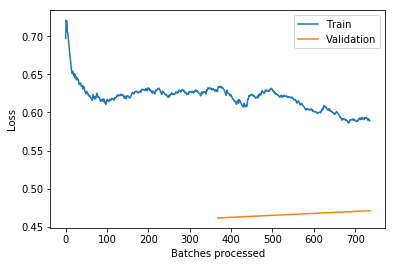

In [5]:
learn.fit_one_cycle(2, 1e-2)
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,fbeta_binary,time
0,0.579864,0.456898,0.822917,0.790123,00:10
1,0.571930,0.435233,0.842917,0.804461,00:10
2,0.556363,0.430391,0.845417,0.807473,00:11


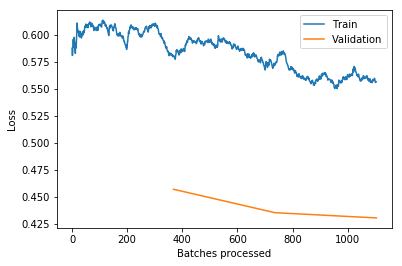

In [6]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,fbeta_binary,time
0,0.553904,0.426940,0.846458,0.804665,00:21
1,0.555887,0.430930,0.846042,0.809093,00:21
2,0.536984,0.430492,0.845833,0.808091,00:21
3,0.544144,0.427652,0.851667,0.813613,00:22
4,0.527425,0.442883,0.839375,0.805842,00:21
5,0.517690,0.442581,0.845833,0.811896,00:21
6,0.512622,0.449809,0.858333,0.818667,00:20
7,0.506225,0.450696,0.858542,0.814734,00:20
8,0.489958,0.450325,0.859375,0.817617,00:21
9,0.480876,0.463396,0.861042,0.816000,00:21


Better model found at epoch 0 with fbeta_binary value: 0.8046646118164062.
Better model found at epoch 1 with fbeta_binary value: 0.8090932369232178.
Better model found at epoch 3 with fbeta_binary value: 0.8136125802993774.
Better model found at epoch 6 with fbeta_binary value: 0.8186666369438171.
Better model found at epoch 11 with fbeta_binary value: 0.8217795491218567.


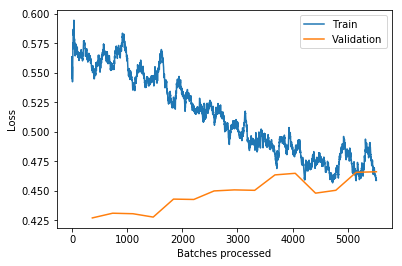

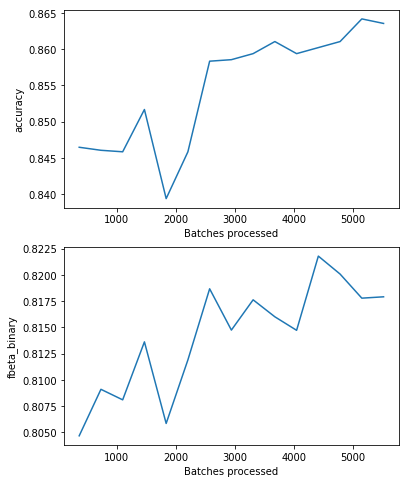

In [7]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-3/(2.6**4),5e-3), moms=(0.7,0.4), pct_start=0.25, div_factor=10.,
                    callbacks=[SaveModelCallback(learn,every='improvement',mode='max',
                                                 monitor='fbeta_binary',name=f'best_acc_model_Q_{seed}')])
learn.recorder.plot_losses()
learn.recorder.plot_metrics()